# Model interpretation

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

## Boston house prices

The Boston house price dataset contains the following information about 506 houses:

- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per \$10,000
- PTRATIO pupil-teacher ratio by town
- B = 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT percentage lower status of the population
- target = MEDV Median value of owner-occupied homes in \$1000’s

The goal is to predict the house price from the other features. We first import the data and do some preprocessing to standardize the data.

In [2]:
from sklearn import datasets
boston = datasets.load_boston()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = boston.data, boston.target
print("number of samples/features: %d, %d" % X.shape)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
print("training/test samples: %d, %d" % (len(y_train), len(y_test)))

# Center and scale features and observations
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
ymean = np.mean(y_train)
y_train = y_train - ymean
y_test = y_test - ymean

number of samples/features: 506, 13
training/test samples: 404, 102


In Lecture 2 we trained a kernel ridge model for this regression task. We can see on the test set that it generalizes well, it does a pretty good job at predicting the house price.

R2-score = 0.855
MAE = 2.482


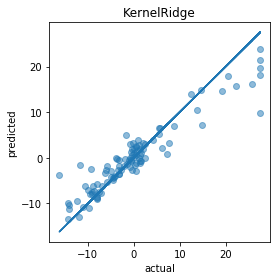

In [3]:
from sklearn import kernel_ridge
from sklearn.metrics import mean_absolute_error

kernel = kernel_ridge.KernelRidge(alpha=0.05, kernel="rbf", gamma=0.5)
kernel.fit(X_train, y_train)
y_pred =  kernel.predict(X_test)
print(f"R2-score = {kernel.score(X_test, y_test):.3f}")
print(f"MAE = {mean_absolute_error(y_test, y_pred):.3f}")

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot(y_test, y_test)
ax.set(title="KernelRidge", ylabel="predicted", xlabel="actual")
fig.tight_layout()

However the resulting model is a black-box and very difficult to interpret. Below we see three strategies to make machine learning models more interpretable:

1. fit simpler models (like sparse linear models) that are more interpretable
2. look at the feature importance for ensemble models
3. partial dependence plots 

## Fit less performant but more interpretable models

Linear models, especially sparse ones with a few number of features, are easy to interpret. Below we fit a sparse linear model (LASSO) on the Boston dataset with the regularization strength set by cross-validation.

R2-score = 0.762
MAE = 3.750
alpha = 0.025


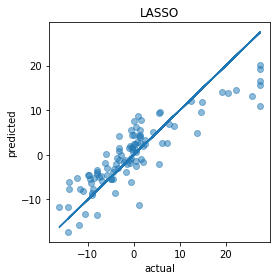

In [4]:
from sklearn.linear_model import LassoCV, lasso_path

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
y_pred =  lasso.predict(X_test)
print(f"R2-score = {lasso.score(X_test, y_test):.3f}")
print(f"MAE = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"alpha = {lasso.alpha_:.3f}")

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot(y_test, y_test)
ax.set(title="LASSO", ylabel="predicted", xlabel="actual")
fig.tight_layout()

We indeed loose some predictive power compared to the kernel ridge regressor (the R2-score decreases and the mean absolute error increases). But the resulting linear model is very simple to interpret.  If we look at the regression coefficients, we can see the relative contribution of each feature to the prediction (remember that all features were standarized to zero mean and unit variance). 

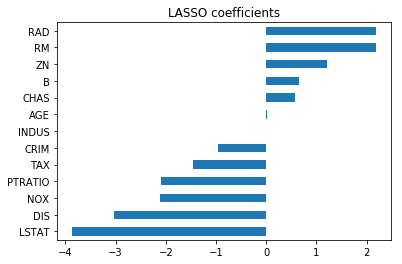

In [5]:
coefficients = pd.Series(lasso.coef_, index=boston.feature_names).sort_values()
coefficients.plot.barh(title="LASSO coefficients");

Below we plot the LASSO path for this model, which shows the regression coefficients at different values of the regularization strength. At higher regularization strength, we get more compact/sparse/simpler models (with many coefficients equal to zero). The features that persist as we increase the regularization strength are, somehow, the more robust ones and have the most predictive power. In our case LSTAT, followed by RM and then PTRATIO, seem to be the most predictive features for the house price.

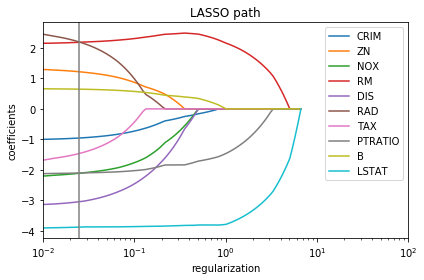

In [6]:
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=0.001, fit_intercept=False)
# to make the plot more readable
dont_show = ["AGE", "INDUS", "CHAS"]
fig, ax = plt.subplots(1,1)
for feature, coef in zip(boston.feature_names, coefs_lasso):
    if feature not in dont_show:
        ax.semilogx(alphas_lasso, coef, label=feature)
ax.legend(loc="upper right")
ax.set_xlim(1e-2,1e2)
plt.axvline(lasso.alpha_, color="grey")
ax.set(title="LASSO path", xlabel="regularization", ylabel="coefficients")
fig.tight_layout()

## Feature importance (ensemble models)

In ensemble models like Random Forest or Gradient Boosting trees, we also have access to the [feature importances](https://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation). It can be useful for model diagnosis and for feature selection. Let us illustrate here with a Gradient Bossting Trees regressor.   

R2-score = 0.908
MAE = 2.206


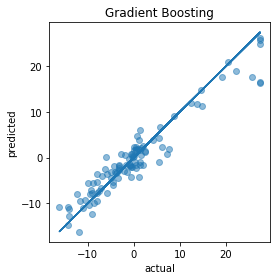

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

boosting = GradientBoostingRegressor(
    n_estimators=100, max_depth=4,
    learning_rate=0.1, loss='huber',
    random_state=1
)
boosting.fit(X_train, y_train)
y_pred =  boosting.predict(X_test)
print(f"R2-score = {boosting.score(X_test, y_test):.3f}")
print(f"MAE = {mean_absolute_error(y_test, y_pred):.3f}")

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot(y_test, y_test)
ax.set(title="Gradient Boosting", ylabel="predicted", xlabel="actual")
fig.tight_layout()

The R2-score and MAE are quite good, we have improved upon the kernel ridge regressor. Of course the resulting model is a complete black box (stacking of many decision trees), but nonetheless the feature importances indicate that LSTAT and RM are the most predictive features in that model.

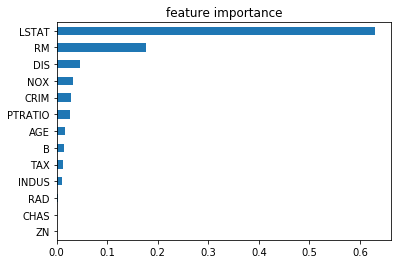

In [8]:
importances = pd.Series(boosting.feature_importances_, index=boston.feature_names).sort_values()
importances.plot.barh(title="feature importance");

## Partial dependence plots

For any black box model we can look at the partial dependence of the model on a given feature,
marginalizing the target prediction over the values of all other features. For instance we show below the partial dependence plots with respect to the three most important features (LSTAT, RM, DIS) in our gradient boosting trees regressor. The house price decreases with LSTAT and increases with RM.

In [9]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

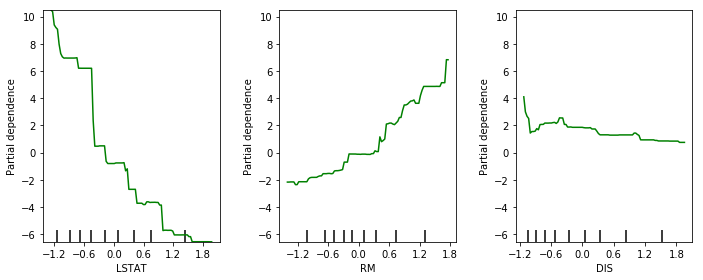

In [10]:
fig, axs = plot_partial_dependence(
    boosting, X_train, features = ["LSTAT", "RM", "DIS"], 
    feature_names=boston.feature_names,
    figsize=(10,4)
)
fig.tight_layout()

## Further resources

The [LIME algorithm](https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf) (Local Interpretable Model-Agnostic Explanations) is available as a [python package](https://github.com/marcotcr/lime) and illustrated on several test cases.

[Generalized additive models](https://en.wikipedia.org/wiki/Generalized_additive_model) are usually very interpretable and yet much more expressive than linear models, as they can model any non-linear relationhsip between the target and each feature. They often have a much higher predictive performance than linear models. GAM are implemented in python in the [pygam](https://pygam.readthedocs.io/en/latest/index.html) package.